
# Seatfinder – Auswertung aus PostgreSQL-SQL-Dump (2016–2024)

**Hinweis:** Dieses Notebook benötigt **nur die `.sql`-Dump-Datei** (mit `CREATE TABLE` + `COPY ... FROM stdin;` Blöcken). Es verwendet **keine** Datenbankverbindung – der Dump wird direkt geparst und in `pandas`-DataFrames geladen.

**Was du tun musst:**  
1. Lege deine Dump-Datei (z. B. `seatfinder_dump.sql`) im gleichen Ordner ab, in dem du dieses Notebook startest, oder passe unten den Pfad in `SQL_DUMP_PATH` an.  
2. Führe die Zellen nacheinander aus.


In [1]:
SQL_DUMP_PATH = "seatfinder_tuebingen_2024-10-15.sql" 

import os, io, re, csv, datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib Defaults – (keine Styles/keine Farben explizit setzen)
plt.rcParams.update({
    "figure.figsize": (9, 4.5),
    "axes.grid": True
})

assert os.path.exists(SQL_DUMP_PATH), f"SQL_DUMP_PATH nicht gefunden: {SQL_DUMP_PATH}"
print("SQL-Dump gefunden:", SQL_DUMP_PATH)

SQL-Dump gefunden: seatfinder_tuebingen_2024-10-15.sql



## Dump-Parser (COPY-Blöcke → DataFrames)

Der Parser liest `COPY schema.table (cols...) FROM stdin;` und sammelt die Tab-getrennten Datenzeilen bis zur Zeile `\.`.  
Leere Werte werden als `NaN` gesetzt, `\N` wird ebenfalls zu `NaN`. Datentypen werden später konvertiert.


In [ ]:
import io, re

COPY_START_RE = re.compile(r'^COPY\s+([a-zA-Z0-9_\."]+)\s*\((.*?)\)\s+FROM\s+stdin;', re.IGNORECASE)
COPY_END = r'\.'

def parse_sql_dump_to_tables(sql_path):
    tables = {}  # key: full table name (e.g., public.locations) -> dict with keys: columns, rows
    current = None
    cols = []
    rows = []
    with io.open(sql_path, "r", encoding="utf-8", errors="ignore") as f:
        for raw_line in f:
            line = raw_line.rstrip("\n")
            if current is None:
                m = COPY_START_RE.match(line)
                if m:
                    current = m.group(1)  # e.g., public.locations
                    col_str = m.group(2)
                    cols = [c.strip().strip('"') for c in col_str.split(",")]
                    rows = []
            else:
                if line == COPY_END:
                    tables.setdefault(current, {"columns": cols, "rows": []})
                    tables[current]["rows"].extend(rows)
                    current = None
                    cols = []
                    rows = []
                else:
                    parts = line.split("\t")
                    if len(parts) < len(cols):
                        parts += [""] * (len(cols) - len(parts))
                    elif len(parts) > len(cols):
                        parts = parts[:len(cols)]
                    parts = [None if p == r"\N" else p for p in parts]
                    rows.append(parts)
    return tables

tables = parse_sql_dump_to_tables(SQL_DUMP_PATH)
print("Gefundene COPY-Tabellen:", list(tables.keys()))


## DataFrames bauen

Wir ziehen die vier relevanten Tabellen in DataFrames:
- `public.locations`
- `public.seat_estimates`
- `public.wlan_clients`
- `public.manual_counts` (falls vorhanden)


In [ ]:
def table_to_df(tables, key):
    t = tables.get(key)
    if not t:
        return None
    df = pd.DataFrame(t["rows"], columns=t["columns"])
    return df

locations = table_to_df(tables, "public.locations")
seat_estimates = table_to_df(tables, "public.seat_estimates")
wlan_clients = table_to_df(tables, "public.wlan_clients")
manual_counts = table_to_df(tables, "public.manual_counts")

for name, df in [("locations", locations), ("seat_estimates", seat_estimates),
                 ("wlan_clients", wlan_clients), ("manual_counts", manual_counts)]:
    if df is None:
        print(f"{name}: nicht im Dump gefunden")
    else:
        print(f"{name}: {df.shape}")

locations: (20, 14)
seat_estimates: (8323622, 5)
wlan_clients: (17489095, 4)
manual_counts: (1177, 5)



## Typen konvertieren

- `timestamp` → `datetime` (naiv, als Europe/Berlin interpretierbar)
- numerische Spalten → `int/float`


In [ ]:
def to_datetime_safe(s):
    return pd.to_datetime(s, errors="coerce")

def to_int_safe(s):
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def to_float_safe(s):
    return pd.to_numeric(s, errors="coerce")

# locations
if locations is not None:
    for c in ["id", "availableseats", "superlocation_id"]:
        if c in locations.columns:
            locations[c] = to_int_safe(locations[c])
    if "timestamp" in locations.columns:
        locations["timestamp"] = to_datetime_safe(locations["timestamp"])

# seat_estimates
if seat_estimates is not None:
    for c in ["id", "location_id", "occupiedseats", "freeseats"]:
        if c in seat_estimates.columns:
            seat_estimates[c] = to_int_safe(seat_estimates[c])
    if "timestamp" in seat_estimates.columns:
        seat_estimates["timestamp"] = to_datetime_safe(seat_estimates["timestamp"])

# wlan_clients
if wlan_clients is not None:
    for c in ["id", "location_id", "numberofclients"]:
        if c in wlan_clients.columns:
            wlan_clients[c] = to_int_safe(wlan_clients[c])
    if "timestamp" in wlan_clients.columns:
        wlan_clients["timestamp"] = to_datetime_safe(wlan_clients["timestamp"])

# manual_counts
if manual_counts is not None:
    for c in ["id", "location_id", "occupiedseats", "freeseats"]:
        if c in manual_counts.columns:
            manual_counts[c] = to_int_safe(manual_counts[c])
    if "timestamp" in manual_counts.columns:
        manual_counts["timestamp"] = to_datetime_safe(manual_counts["timestamp"])

# Nützliche Lookup-Infos
if locations is not None:
    loc_lookup = locations.set_index("id")[["name","longname","availableseats"]]
else:
    loc_lookup = pd.DataFrame()

print("Konvertierung fertig.")

Konvertierung fertig.



## (Optional) CSV-Exporte

Praktisch, wenn man die Aggregationen außerhalb des Notebooks prüfen möchte.


In [ ]:
OUTDIR = "exports"
os.makedirs(OUTDIR, exist_ok=True)

if locations is not None: locations.to_csv(os.path.join(OUTDIR, "locations.csv"), index=False)
if seat_estimates is not None: seat_estimates.to_csv(os.path.join(OUTDIR, "seat_estimates.csv"), index=False)
if wlan_clients is not None: wlan_clients.to_csv(os.path.join(OUTDIR, "wlan_clients.csv"), index=False)
if manual_counts is not None: manual_counts.to_csv(os.path.join(OUTDIR, "manual_counts.csv"), index=False)

print("CSV-Exporte in:", OUTDIR)

CSV-Exporte in: exports


In [ ]:
# Basis: join + casting + clipping + 5-Min-Slots
se = seat_estimates.merge(
    locations[["id","name","longname","availableseats"]],
    left_on="location_id", right_on="id", how="left"
).rename(columns={"availableseats":"capacity"})

# numeric + timestamps
se["timestamp"] = pd.to_datetime(se["timestamp"], errors="coerce")
se["occ"]  = pd.to_numeric(se["occupiedseats"], errors="coerce")
se["cap"]  = pd.to_numeric(se["capacity"], errors="coerce")

# gültige Messungen
se = se.dropna(subset=["timestamp","occ","cap"])
se = se[se["cap"] > 0]

# plausibles Intervall
se["occ"] = se["occ"].clip(lower=0, upper=se["cap"])

# 5-Minuten-Slots
se["t5"] = se["timestamp"].dt.floor("5min")



## 1) Langfristiger Trend (täglich, gesamt)

Aggregiert `seat_estimates` auf Tagesebene und glättet mit 30-Tage-Rolling.


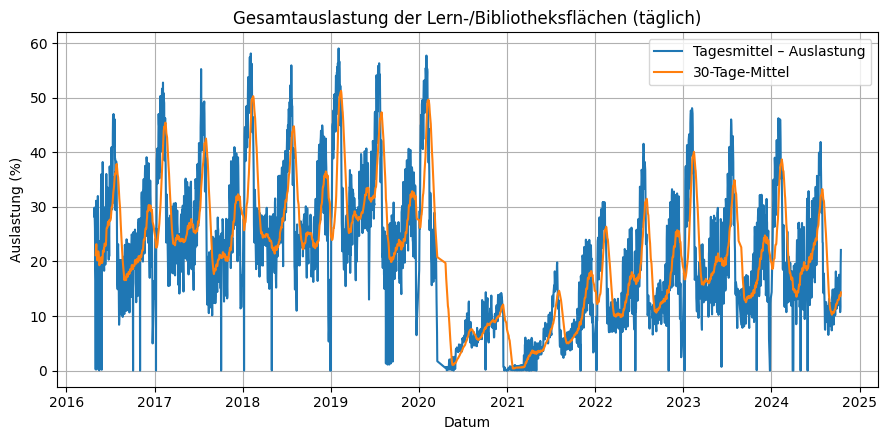

In [ ]:
# pro Standort & Slot mitteln (falls mehrere Messungen im Slot)
slot_by_loc = se.groupby(["t5","location_id"], as_index=False)["occ"].mean()

# Gesamtnutzung je Slot (Summe über Standorte)
slot_total = slot_by_loc.groupby("t5", as_index=False)["occ"].sum().rename(columns={"occ":"occ_total"})

# Gesamtkapazität (konstant; Summe aller Standorte mit cap>0)
cap_total = float(se.groupby("location_id")["cap"].max().sum())

# Tagesmittel (über Slots) für Nutzung & Auslastung
slot_total["d"] = slot_total["t5"].dt.floor("D")
daily = slot_total.groupby("d", as_index=False)["occ_total"].mean()
daily["util"] = daily["occ_total"] / cap_total
daily = daily.sort_values("d")
daily["util_ma30"] = daily["util"].rolling(30, min_periods=7).mean()

# Plot als Prozent
plt.figure()
plt.plot(daily["d"], daily["util"]*100, label="Tagesmittel – Auslastung")
plt.plot(daily["d"], daily["util_ma30"]*100, label="30-Tage-Mittel")
plt.title("Gesamtauslastung der Lern-/Bibliotheksflächen (täglich)")
plt.xlabel("Datum"); plt.ylabel("Auslastung (%)")
plt.legend(); plt.tight_layout(); plt.show()



## 2) Vor / Während / Nach Corona – Vergleich (gesamt)

Grober Phasenvergleich – Fenster ggf. anpassen.


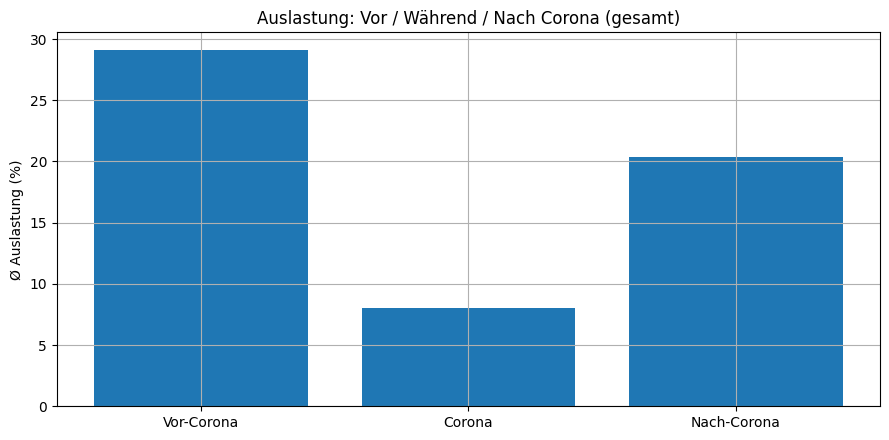

In [ ]:
PHASES = [
    ("Vor-Corona",  pd.Timestamp("2016-04-01"), pd.Timestamp("2020-03-15")),
    ("Corona",      pd.Timestamp("2020-03-16"), pd.Timestamp("2022-03-31")),
    ("Nach-Corona", pd.Timestamp("2022-04-01"), pd.Timestamp("2024-10-31")),
]

phase_vals = []
for label, start, end in PHASES:
    m = (daily["d"]>=start) & (daily["d"]<=end)
    phase_vals.append((label, float(daily.loc[m,"util"].mean())*100))

pm = pd.DataFrame(phase_vals, columns=["Phase","Auslastung_%"])

plt.figure()
plt.bar(pm["Phase"], pm["Auslastung_%"])
plt.title("Auslastung: Vor / Während / Nach Corona (gesamt)")
plt.ylabel("Ø Auslastung (%)")
plt.tight_layout(); plt.show()



## 3) Wochentags-Muster (Boxplot) – Beispiel PCB

**PCB-Standorte** grob anhand `locations.name` gefiltert (`UBC*`, `UBN*`, `UBLZN`). Passe den Filter gerne an.


<Figure size 900x450 with 0 Axes>

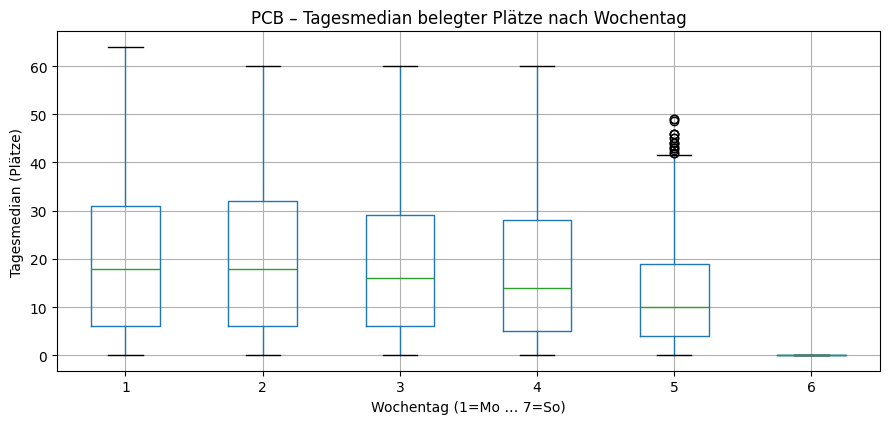

In [ ]:
# Tagesmedian je Standort (robuster)
se["d"] = se["timestamp"].dt.floor("D")
daily_loc = se.groupby(["location_id","name","d"], as_index=False)["occ"].median()

# PCB grob (nach Name): UBC*, UBN*, UBLZN
pcb = daily_loc[daily_loc["name"].str.startswith(("UBC","UBN","UBLZN"), na=False)].copy()
pcb["iso_dow"] = pd.to_datetime(pcb["d"]).dt.dayofweek + 1

plt.figure()
pcb.boxplot(column="occ", by="iso_dow")
plt.title("PCB – Tagesmedian belegter Plätze nach Wochentag")
plt.suptitle("")
plt.xlabel("Wochentag (1=Mo … 7=So)"); plt.ylabel("Tagesmedian (Plätze)")
plt.tight_layout(); plt.show()



## 4) Tageszeiten-Heatmap (Uhrzeit × Wochentag) – Beispiel-Standort

Wähle einen Standortnamen (`SITE_NAME`) aus `locations.name`.


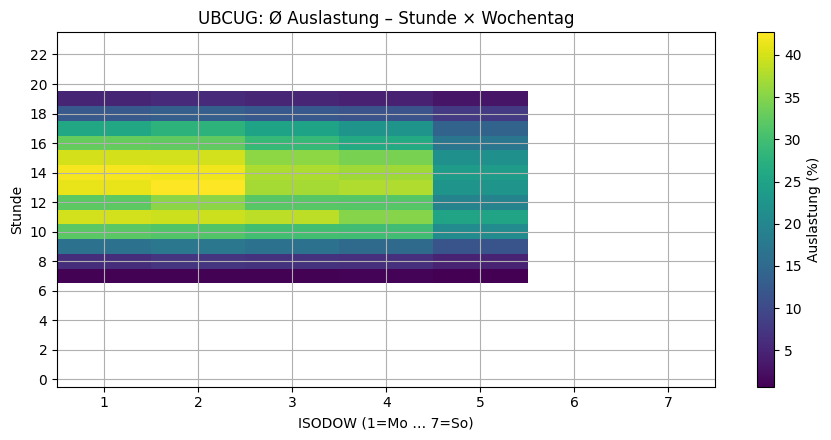

In [ ]:
SITE_NAME = "UBCUG"  # anpassen

site = se[se["name"]==SITE_NAME].copy()
site["util"] = site["occ"] / site["cap"]
site["hour"] = site["timestamp"].dt.hour
site["iso_dow"] = site["timestamp"].dt.dayofweek + 1

heat = site.groupby(["hour","iso_dow"], as_index=False)["util"].mean()
pivot = heat.pivot(index="hour", columns="iso_dow", values="util")
pivot = pivot.reindex(index=range(0,24), columns=range(1,8))

arr = pivot.to_numpy(dtype=float)

plt.figure()
im = plt.imshow(arr*100, aspect="auto", origin="lower")
plt.title(f"{SITE_NAME}: Ø Auslastung – Stunde × Wochentag")
plt.xlabel("ISODOW (1=Mo … 7=So)"); plt.ylabel("Stunde")
plt.xticks(ticks=np.arange(0,7), labels=[1,2,3,4,5,6,7])
plt.yticks(ticks=np.arange(0,24,2), labels=np.arange(0,24,2))
plt.colorbar(im, label="Auslastung (%)")
plt.tight_layout(); plt.show()



## 5) Standorte vergleichen – Spitzenlast & Auslastungsquote

Berechnet die **durchschnittliche tägliche Spitzenauslastung** und setzt sie ins Verhältnis zur Kapazität (`locations.availableseats`).


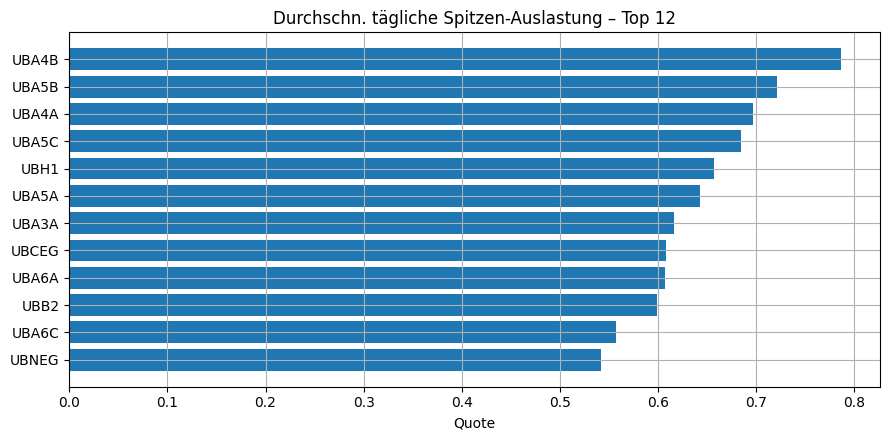

In [ ]:
# Tages-Peaks je Standort
day_peaks = (
    se.groupby(["location_id","name","cap","d"], as_index=False)["occ"]
      .max()
      .rename(columns={"occ":"peak"})
)
day_peaks["peak_ratio"] = day_peaks["peak"] / day_peaks["cap"]

# über Tage mitteln
ranked = (
    day_peaks.groupby(["location_id","name"], as_index=False)["peak_ratio"]
      .mean()
      .sort_values("peak_ratio", ascending=False)
)

top = ranked.head(12)
plt.figure()
plt.barh(top["name"], top["peak_ratio"])
plt.title("Durchschn. tägliche Spitzen-Auslastung – Top 12")
plt.xlabel("Quote"); plt.gca().invert_yaxis()
plt.tight_layout(); plt.show()



## 6) WLAN-Clients vs. belegte Plätze (Validierung/Proxy)

Join auf 5-Minuten-Slots. Standort über `SITE_NAME_WIFI` wählen.


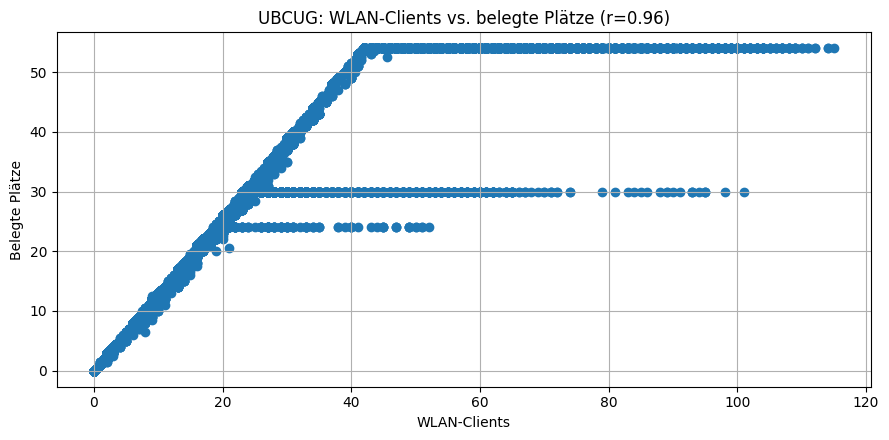

In [ ]:
SITE_NAME_WIFI = "UBCUG"

se_site = se[se["name"]==SITE_NAME_WIFI].copy()
se_slot  = se_site.groupby("t5", as_index=False)["occ"].mean()

wl = wlan_clients.merge(locations[["id","name"]], left_on="location_id", right_on="id", how="left")
wl = wl[(wl["name"]==SITE_NAME_WIFI)]
wl["timestamp"] = pd.to_datetime(wl["timestamp"], errors="coerce")
wl["numberofclients"] = pd.to_numeric(wl["numberofclients"], errors="coerce")
wl = wl.dropna(subset=["timestamp","numberofclients"])
wl["t5"] = wl["timestamp"].dt.floor("5min")
wl_slot = wl.groupby("t5", as_index=False)["numberofclients"].mean()

merged = pd.merge(se_slot, wl_slot, on="t5", how="inner")

if len(merged) < 200:
    print("Zu wenige gemeinsame Slots – bitte längeren Zeitraum/anderen Standort wählen.")
else:
    r = np.corrcoef(merged["numberofclients"], merged["occ"])[0,1]
    plt.figure()
    plt.scatter(merged["numberofclients"], merged["occ"])
    plt.title(f"{SITE_NAME_WIFI}: WLAN-Clients vs. belegte Plätze (r={r:.2f})")
    plt.xlabel("WLAN-Clients"); plt.ylabel("Belegte Plätze")
    plt.tight_layout(); plt.show()



## 7) Manuelle Zählungen vs. Schätzungen (Qualitätscheck)

Jede manuelle Zählung wird der zeitnächsten Schätzung (±10 Min) zugeordnet.


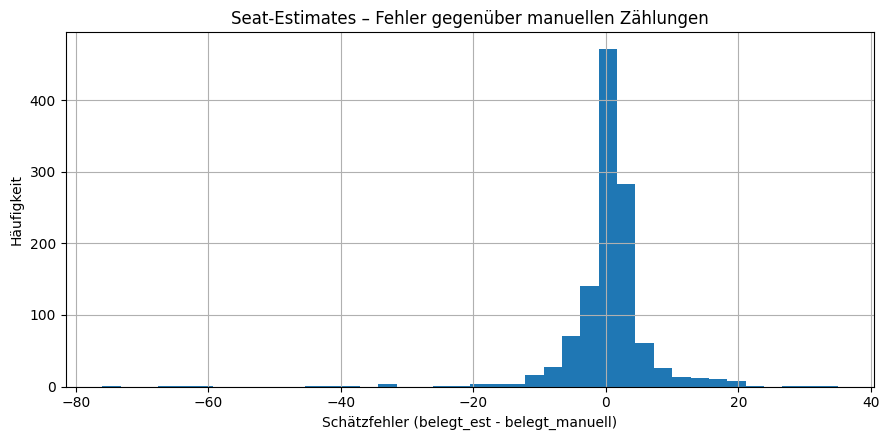

In [ ]:
if manual_counts is None or manual_counts.empty:
    print("Keine 'manual_counts' im Dump – dieser Abschnitt wird übersprungen.")
else:
    mc = manual_counts.dropna(subset=["timestamp"]).copy()
    se6 = seat_estimates.copy()

    mc["left"] = mc["timestamp"] - pd.Timedelta(minutes=10)
    mc["right"] = mc["timestamp"] + pd.Timedelta(minutes=10)

    se6 = se6.dropna(subset=["timestamp"])
    merged_list = []
    for loc_id, grp in mc.groupby("location_id"):
        se_loc = se6[se6["location_id"]==loc_id]
        if se_loc.empty:
            continue
        for _, row in grp.iterrows():
            window = se_loc[(se_loc["timestamp"]>=row["left"]) & (se_loc["timestamp"]<=row["right"])]
            if window.empty: 
                continue
            idx = (window["timestamp"] - row["timestamp"]).abs().idxmin()
            best = window.loc[idx]
            merged_list.append({
                "location_id": loc_id,
                "mc_ts": row["timestamp"],
                "mc_occ": row["occupiedseats"],
                "est_ts": best["timestamp"],
                "est_occ": best["occupiedseats"]
            })
    qual = pd.DataFrame(merged_list)
    if qual.empty:
        print("Keine passenden Paare gefunden (Zeitfenster zu eng?)")
    else:
        qual["err"] = qual["est_occ"] - qual["mc_occ"]
        plt.figure()
        plt.hist(qual["err"].dropna(), bins=40)
        plt.title("Seat-Estimates – Fehler gegenüber manuellen Zählungen")
        plt.xlabel("Schätzfehler (belegt_est - belegt_manuell)")
        plt.ylabel("Häufigkeit")
        plt.tight_layout(); plt.show()


## 8) Saisonale Signatur (Monatsmittel, 2016–2024)


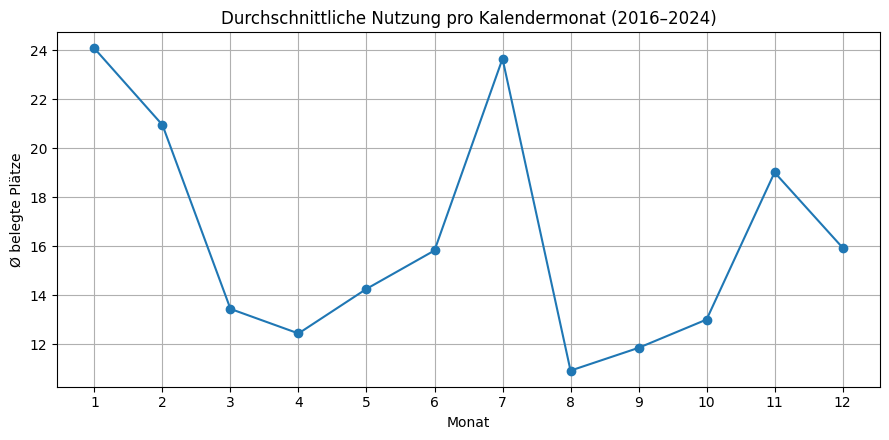

In [ ]:
se7 = seat_estimates.dropna(subset=["timestamp"]).copy()
se7["month"] = se7["timestamp"].dt.to_period("M").dt.to_timestamp()
monthly = se7.groupby("month")["occupiedseats"].mean().reset_index(name="avg_occ")

m = monthly.copy()
m["mm"] = m["month"].dt.month
season = m.groupby("mm")["avg_occ"].mean().reset_index()

plt.figure()
plt.plot(season["mm"], season["avg_occ"], marker="o")
plt.xticks(range(1,13))
plt.title("Durchschnittliche Nutzung pro Kalendermonat (2016–2024)")
plt.xlabel("Monat"); plt.ylabel("Ø belegte Plätze")
plt.tight_layout(); plt.show()


---

### Appendix: Nützliche Helfer

- `loc_lookup`: Mapping von `location_id` → `(name, longname, availableseats)`  
- Beispiel: `loc_lookup.loc[19]`
